In [73]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torchvision import transforms,datasets,models

In [74]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

In [75]:
train.shape, test.shape

((42000, 785), (28000, 784))

In [76]:
train_data = []
test_data = []
img_size = (28,28)

In [77]:
for i in range(train.shape[0]):
    data = train.iloc[i,1:]
    data = np.array(data)
    data = np.reshape(data, img_size)
    train_data.append(data)
train_data = np.array(train_data)

In [78]:
train_data.shape

(42000, 28, 28)

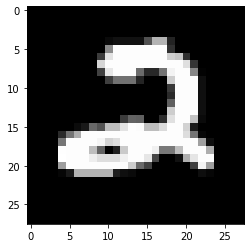

In [79]:
for i in range(test.shape[0]):
    data = test.iloc[i,:]
    data = np.array(data)
    data = np.reshape(data, img_size)
    test_data.append(data)
test_data = np.array(test_data)
plt.imshow(test_data[0],cmap="gray")
plt.show()

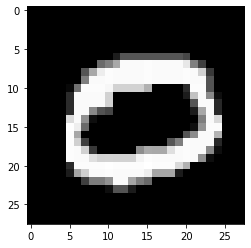

In [80]:
plt.imshow(test_data[1],cmap="gray")
plt.show()

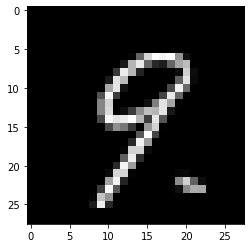

In [81]:
plt.imshow(test_data[2],cmap="gray")
plt.show()

In [82]:
test_data.shape

(28000, 28, 28)

In [83]:
labels = list(train.iloc[:,0])
labels = np.array(labels)
labels = np.reshape(labels, (train.shape[0], 1))

In [84]:
labels.shape

(42000, 1)

In [85]:
class ImageTransform():
    def __init__(self):
        self.data_transform = {
            "train":transforms.Compose(
                [transforms.ToTensor()]
            ),
            "test":transforms.Compose([
                transforms.ToTensor()
            ])
        }
    def __call__(self, img, phase="train"):
        return self.data_transform[phase](img)

In [86]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, datas, labels, transform=None, phase="train"):
        self.datas = datas
        self.labels = labels
        self.transform = transform
        self.phase = phase
        self.img_size = img_size
    def __len__(self):
        return len(self.datas)
    def __getitem__(self, index):
        img = self.datas[index]
        img_transformed = self.transform(img, self.phase)
        if self.labels is not None:
            label = self.labels[index][0]
            label = torch.tensor(label)
            label = label.type(torch.LongTensor)
            return img_transformed, label
        else:
            return img_transformed

In [87]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128,out_channels=256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=256,out_channels=128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=3*3*128, out_features=10)
    def forward(self,x):
        x = x.to(torch.float32)
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x

In [88]:
batch_size = 32
train_dataset = Dataset(train_data, labels, transform=ImageTransform(), phase="train")
test_dataset = Dataset(test_data, labels=None, transform=ImageTransform(), phase="test")

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, 1, shuffle=False)

In [89]:
model = CNN()
device = torch.device("mps")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)


In [90]:
num_epochs = 50

for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch, num_epochs))
    print("------------------")
    epoch_loss = 0.0
    epoch_corrects = 0
    
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        preds = torch.max(outputs, 1)[1]
        loss.backward()
        optimizer.step()
        
        epoch_loss+=loss.item()*inputs.size(0)
        epoch_corrects+=torch.sum(preds==labels.data)
        
    epoch_loss = epoch_loss/len(train_dataloader.dataset)
    epoch_acc = float(epoch_corrects)/len(train_dataloader.dataset)
    print("Train Loss {:.4f} Acc {:.4f}".format(epoch_loss, epoch_acc))

Epoch 0/50
------------------
Train Loss inf Acc 0.9317
Epoch 1/50
------------------
Train Loss 0.0736 Acc 0.9781
Epoch 2/50
------------------
Train Loss 0.0607 Acc 0.9817
Epoch 3/50
------------------
Train Loss 0.0542 Acc 0.9837
Epoch 4/50
------------------
Train Loss 0.0478 Acc 0.9850
Epoch 5/50
------------------
Train Loss 0.0492 Acc 0.9864
Epoch 6/50
------------------
Train Loss 0.0433 Acc 0.9875
Epoch 7/50
------------------
Train Loss 0.0386 Acc 0.9885
Epoch 8/50
------------------
Train Loss 0.0339 Acc 0.9898
Epoch 9/50
------------------
Train Loss 0.0384 Acc 0.9891
Epoch 10/50
------------------
Train Loss 0.0340 Acc 0.9893
Epoch 11/50
------------------
Train Loss 0.0316 Acc 0.9905
Epoch 12/50
------------------
Train Loss 0.0328 Acc 0.9902
Epoch 13/50
------------------
Train Loss 0.0336 Acc 0.9902
Epoch 14/50
------------------
Train Loss 0.0295 Acc 0.9915
Epoch 15/50
------------------
Train Loss 0.0281 Acc 0.9916
Epoch 16/50
------------------
Train Loss 0.0332 Acc 

In [91]:
test_preds = []
imageId = 1
for inputs in test_dataloader:
    optimizer.zero_grad()
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    test_preds.append([imageId, preds.cpu().detach().numpy()[0]])
    imageId+=1

In [92]:
len(test_preds)

28000

In [93]:
submission = pd.DataFrame(test_preds)
submission.columns=['ImageId', "Label"]

In [94]:
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [95]:
submission.to_csv("submission.csv", index=False)